# CIFAR10 with fastai
A few years ago I spent some time playing around with [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). This is a dataset consisting of 10 classes, 50,000 for training and 10,000 for testing. Each image is 32x32 RGB. Back then I had an old CUDA card that didn't support any of the popular frameworks for machine learning. So I ended up writing my own CNN code using CUDA from scratch. This took a bit of time but it was fun. My results were okay back then, a bit over 80% accuracy for validationa and testing. In this post I'm revisting CIFAR10 but this time I'm going to use fastai. I'm expecting to get much better results with less effort this time!

1. [Load the CIFAR10 dataset](#load)
2. [Training and evaluation](#train)
3. [Some thoughts](#thoughts)

# 1. Load the CIFAR10 dataset<a name="load"></a>
We can use fastai's builtin function to load CIFAR10. This is a convenient one liner.

In [1]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

path = untar_data(URLs.CIFAR)

# 2. Training and evaluation<a name="train"></a>
I'm going to use a pre-trained resnet18 and do transfer learning. In an attempt to speed things up (since I'm paying by the second on Paperspace!) I'll use float16 for training. This is done by calling .to_fp16() on the cnn_learner. Resnet was originally trained on images with size 224x224, but CIFAR10 images are smaller 32x32. This isn't a blocker, as we can train on any image size but it may not give good results. As an experiment I'll train on images of size 32x32, 64x64, 128x128 and 224x224. 

The training parameters are pretty simple. There's no data augmentation or any other tricks. The head is trained for 3 epochs and the rest for 10 epochs.

32x32, test accuracy=0.49950000643730164


64x64, test accuracy=0.7325000166893005


128x128, test accuracy=0.8483999967575073


224x224, test accuracy=0.8312000036239624


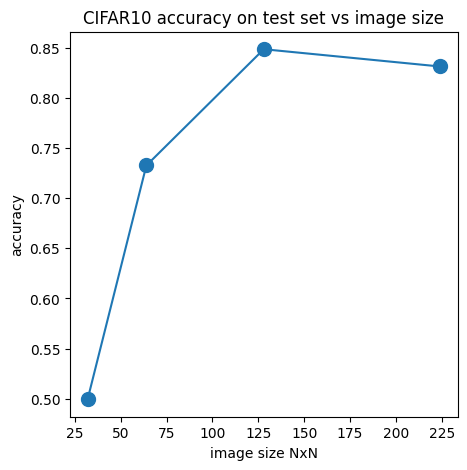

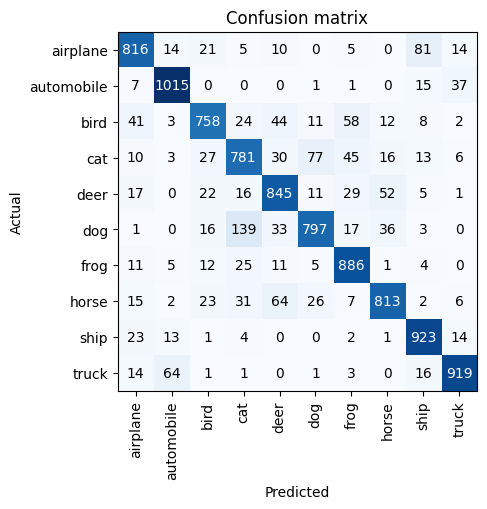

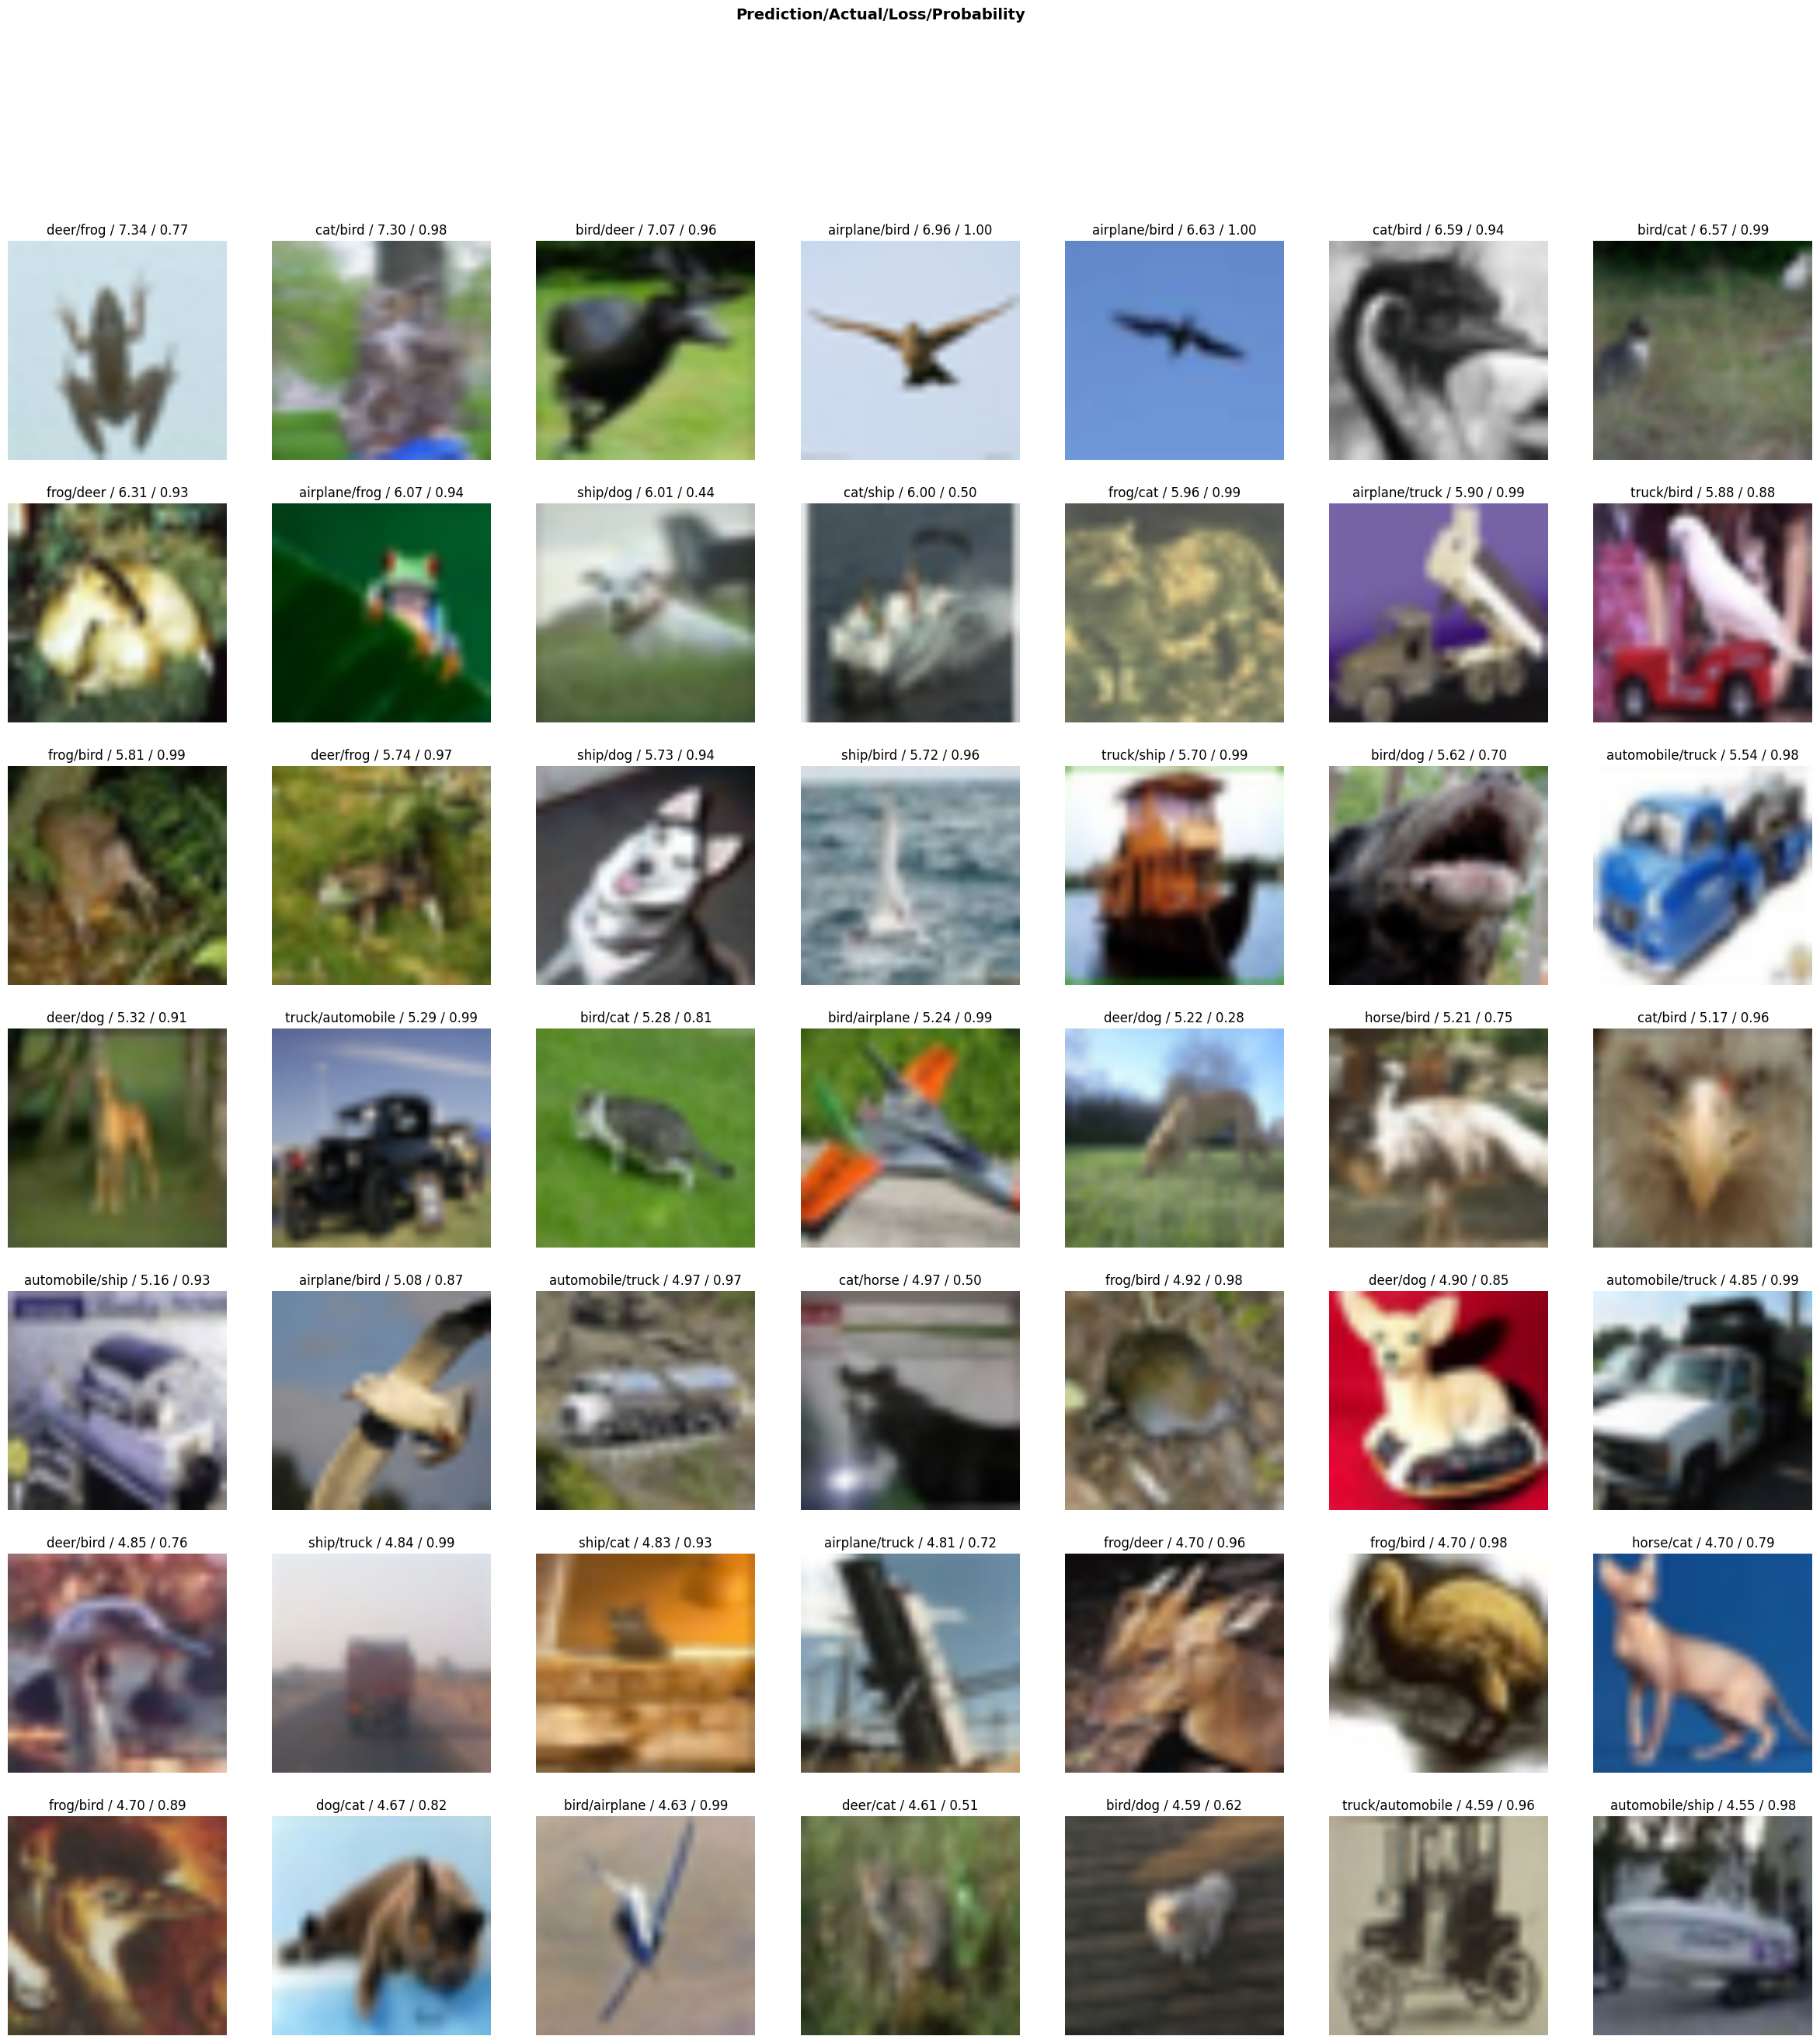

In [21]:
xs = []
ys = []
best_s = []
best_acc = 0
best_learn = None

for s in [32, 64, 128, 224]:
    dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                       get_items=get_image_files,
                       get_y=parent_label,
                       item_tfms=Resize(s))

    dls = dblock.dataloaders(os.path.join(path.__str__(), "train"), bs=64)

    learn = vision_learner(dls, models.resnet18, metrics=accuracy).to_fp16()
    learn.fine_tune(10, freeze_epochs=3)
    learn.save(f"cifar10_{s}")
    
    # run on test set
    test_files = get_image_files(path / "test")
    label = TensorCategory([dls.vocab.o2i[parent_label(f)] for f in test_files])

    pred = learn.get_preds(dl=dls.test_dl(test_files))
    acc = accuracy(pred[0], label).item()
    print(f"{s}x{s}, test accuracy={acc}")    
    
    if acc > best_acc:
        best_s = s
        best_acc = acc
        best_learn = learn
        
    xs.append(s)
    ys.append(acc)
    
plt.figure(figsize=(5,5))
plt.plot(xs, ys, 'o-', markersize=10)
plt.xlabel("image size NxN")
plt.ylabel("accuracy")
plt.title("CIFAR10 accuracy on test set vs image size");    

interp = ClassificationInterpretation.from_learner(best_learn)
interp.plot_confusion_matrix(figsize=(5,5))
interp.plot_top_losses(49, figsize=(30,30))

As the image size increases so does the test accuracy. The accuray plateaus after 128x128 at around 85%. The best accuracy for CIFAR10 is >99% according to [benchmarks.ai](https://benchmarks.ai/cifar-10).

# 3. Some thoughts<a name="thoughts">
I got 85% accuracy with not too much effort. Adding augmentation and longer training time should boost it a bit more. 